# Description
- This notebook contains all the 5 functionalities of the Time Aware Knowledge Graphs (TAKG) project.

In [ ]:
import pandas as pd
from constants import TABLES, STANDARD_TRIPLES, SOURCES,PREDICATES, PLAYER_COLUMNS, TEAM_COLUMNS, TEMPORAL_DATA_COLUMNS, \
    PLAYER_COLUMN_PREDICATE_MAPPING, TEAM_COLUMN_PREDICATE_MAPPING, AWARD_COLUMNS, AWARD_COLUMN_PREDICATE_MAPPING, \
     AWARD_TEMPORAL_COLUMNS, EVENT_COLUMNS, EVENT_COLUMN_PREDICATE_MAPPING, EVENT_TEMPORAL_COLUMNS
from util import get_data, get_all_data, get_row_count, insert_data_to_table, query_TAKG, entity_data_to_triples, \
      entity_to_parent, add_statement_id, transform_player_concept_results, get_player_award_insertion_data,  \
     get_player_event_participation_data, get_player_transfer_market_data, get_player_market_value_insertion_data, \
     get_player_transfer_market_data, process_player_transfer_market_data, transform_player_SPARQL_results, \
     player_played_for_data, delete_table

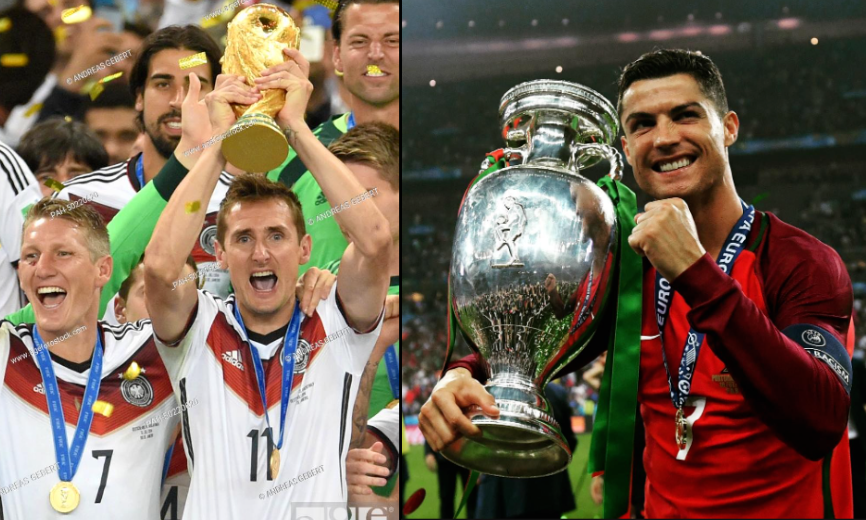

## Players
- <b>Bastian Schweinsteiger</b> (URI TAKG.p2514)
- <b> Miroslav Klose</b> (URI TAKG.p10)
- <b> Cristiano Ronaldo</b> (URI TAKG.p8198)

In [ ]:
q="""SELECT
  t.subject ,t.predicate,t.object, t.statement_id from KG t  WHERE t.subject='TAKG.p2514'
  """
query_TAKG(q)

## Functionality 1
### What awards did the player won and when? e.g. European golden shoe
#### Source : Wikidata

#### 1.1 Existing Knowledge Search

In [ ]:
q = """SELECT
  t.subject AS player_uri,t.object AS award_uri,start,end,time_point,source,insertion_time,
  MAX(CASE WHEN p.predicate = 'hasFullName' THEN p.object END) AS 'Player Name',
  MAX(CASE WHEN p.predicate = 'hasWikiID' THEN p.object END) AS 'player_wikiID',
  MAX(CASE WHEN p.predicate = 'hasTransferMarketID' THEN p.object END) AS 'TransferMarketID',
  MAX(CASE WHEN awd.predicate = 'RDFS.label' THEN awd.object END) AS 'award',
  MAX(CASE WHEN awd.predicate = 'hasWikiID' THEN awd.object END) AS 'award_wikiID'

FROM KG t
JOIN KG p
  ON t.subject = p.subject
JOIN KG awd
  ON t.object=awd.subject

INNER JOIN Temporal ON t.statement_id=Temporal.statement_id
INNER JOIN Metadata ON Temporal.retrieval_id = Metadata.retrieval_id


WHERE t.subject ='TAKG.p2514' AND t.predicate = 'wasAwarded'

GROUP BY t.subject,t.object,insertion_time

"""

In [ ]:
query_TAKG(q)[['player_uri','Player Name', 'award_uri','award', 'start', 'end', 'time_point', 'source',
       'insertion_time',  'player_wikiID', 'TransferMarketID',
        'award_wikiID']]

#### 1.2 Query External Source

In [ ]:
player_award_query = """PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

SELECT DISTINCT  ?player ?transferMarketID ?award ?awardLabel ?time_point
WHERE {

  ?player wdt:P2446 ?transferMarketID;
               p:P166 ?award_statement.
  
  ?award_statement pq:P585 ?time_point;
                   ps:P166 ?award.
  ?award rdfs:label ?awardLabel.

  FILTER (langMatches( lang(?awardLabel), "EN" ) )
  VALUES ?transferMarketID {'2514'} #given player
  
  }
"""

In [ ]:
#2. Get External Knowledge & Transform
player_awards_results = get_all_data(player_award_query)
transformed_player_award_data = transform_player_concept_results(player_awards_results,'award')
#transformed_player_award_data[['player_uri','transferMarketID','award_uri','awardLabel', 'time_point','player', 'award' ]]

#### 1.3 Construct Data

In [ ]:
award_data = get_data(transformed_player_award_data,AWARD_COLUMNS)
#print('#####award T Box####\n')
classes_to_parent_triples = entity_to_parent(award_data)
#print(classes_to_parent_triples)

#award triples
award_triples = entity_data_to_triples(award_data,'award_uri',AWARD_COLUMN_PREDICATE_MAPPING)
#print('####### award A Box ########\n')
#print(award_triples.head())

#print('####### Making Quintiples for insertion into KG table#########\n')

classes_KG_data = add_statement_id(classes_to_parent_triples,STANDARD_TRIPLES)
#print('#####award Classes Statements####\n')
#print(classes_KG_data.head())

award_KG_data = add_statement_id(award_triples,STANDARD_TRIPLES)
#print('#####award Triples Statements####\n')
#print(award_KG_data.head())

#award temporal data
player_award_temporal_data = get_data(transformed_player_award_data,AWARD_TEMPORAL_COLUMNS)
#print('####### Player_award_TEMPORAL Data ########\n')
#print(player_award_temporal_data)

player_award_kg_data,player_award_temporal_data,player_award_metadata = get_player_award_insertion_data(transformed_player_award_data,SOURCES['wiki_source'], \
     PREDICATES['player_award'])

print('#####award KG Statements####\n')
print(player_award_kg_data.head())
print('#####award Temporal Statements####\n')
print(player_award_temporal_data.head())
print('#####award Metadata Statements####\n')
print(player_award_metadata.head())

#### 1.4 Insert Data

In [ ]:
print('#####Counts BEFORE Insertion#####\n')
print('Total KG row count: ',get_row_count(TABLES['base_KG_table'])['row_count'][0])
print('Total Temporal row count: ',get_row_count(TABLES['temporal_meta_table'])['row_count'][0])
print('Total Metadata row count: ',get_row_count(TABLES['meta_table'])['row_count'][0])

In [ ]:
#4. Insert the player award  data

insert_data_to_table(classes_KG_data,'KG')
insert_data_to_table(award_KG_data,'KG')
insert_data_to_table(player_award_kg_data,'KG')
insert_data_to_table(player_award_temporal_data,'Temporal')
insert_data_to_table(player_award_metadata,'Metadata')

print('\n#####Counts AFTER Insertion#####\n')
print('Total KG row count: ',get_row_count(TABLES['base_KG_table'])['row_count'][0])
print('Total Temporal row count: ',get_row_count(TABLES['temporal_meta_table'])['row_count'][0])
print('Total Metadata row count: ',get_row_count(TABLES['meta_table'])['row_count'][0])

In [ ]:
#connect to database and retrieve results
query_TAKG(q)[['player_uri','Player Name', 'award_uri','award', 'time_point', 'source',
       'insertion_time',  'player_wikiID', 'TransferMarketID',
        'award_wikiID']]

## Functionality 2
### What major footballing events did the player participate in? e.g World Cup
#### Source : Wikidata

#### 2.1 Existing Knowledge Search

In [ ]:
q = """SELECT
  t.subject AS player_uri,t.object AS event_uri,strftime('%Y',start) AS year,start,end,time_point,source,insertion_time,
  MAX(CASE WHEN p.predicate = 'hasFullName' THEN p.object END) AS 'Player Name',
  MAX(CASE WHEN p.predicate = 'hasWikiID' THEN p.object END) AS 'player_wikiID',
  MAX(CASE WHEN p.predicate = 'hasTransferMarketID' THEN p.object END) AS 'TransferMarketID',
  MAX(CASE WHEN event.predicate = 'RDFS.label' THEN event.object END) AS 'event',
  MAX(CASE WHEN event.predicate = 'hasWikiID' THEN event.object END) AS 'event_wikiID'

FROM KG t
JOIN KG p
  ON t.subject = p.subject
JOIN KG event
  ON t.object=event.subject

INNER JOIN Temporal ON t.statement_id=Temporal.statement_id
INNER JOIN Metadata ON Temporal.retrieval_id = Metadata.retrieval_id


WHERE t.subject ='TAKG.p2514' AND t.predicate = 'participatedIn'

GROUP BY t.subject,t.object,insertion_time

"""

In [ ]:
query_TAKG(q)[['player_uri','Player Name', 'event_uri','event', 'year', 'start', 'end',
       'source', 'insertion_time', 'player_wikiID','TransferMarketID',  'event_wikiID','time_point']]

#### 2.2 Query External Source

In [ ]:
major_events_query = """
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 


SELECT DISTINCT  ?player ?transferMarketID ?event ?eventLabel ?time_point ?startTime ?endTime
WHERE {

  ?player  wdt:P2446 ?transferMarketID;
           wdt:P1344 ?event.
  
  ?event rdfs:label ?eventLabel.
  ?event wdt:P580 ?startTime.
  OPTIONAL{?event wdt:P582 ?endTime}.
  OPTIONAL{?event wdt:P585 ?time_point}.
  
  FILTER (langMatches( lang(?eventLabel), "EN" ) )
  VALUES ?transferMarketID {'2514'} #given player
  
  }
"""

In [ ]:
#2. Get External Knowledge & Transform
player_event_participation_results = get_all_data(major_events_query)
transformed_player_event_participation_data = transform_player_concept_results(player_event_participation_results,'event')

#### 2.3 Construct Data

In [ ]:
#3. construct Data
#print('#####Event T Box####\n')
classes_to_parent_triples = entity_to_parent(transformed_player_event_participation_data[EVENT_COLUMNS])
#print(classes_to_parent_triples)

#award triples
event_data = get_data(transformed_player_event_participation_data,EVENT_COLUMNS)
event_triples = entity_data_to_triples(event_data,'event_uri',EVENT_COLUMN_PREDICATE_MAPPING)
#print('####### Event A Box ########\n')
#print(event_triples.head())

#print('####### Making Quintiples for insertion into KG table#########\n')

classes_KG_data = add_statement_id(classes_to_parent_triples,STANDARD_TRIPLES)
#print('#####Event Classes Statements####\n')
#print(classes_KG_data.head())
event_KG_data = add_statement_id(event_triples,STANDARD_TRIPLES)
#print('#####Event Triples Statements####\n')
#print(event_KG_data.head())

#event participation temporal data
player_event_temporal_data = get_data(transformed_player_event_participation_data,EVENT_TEMPORAL_COLUMNS)
#print('####### Player_event_participation_TEMPORAL Data ########\n')
#print(player_event_temporal_data)

player_event_participation_kg_data,player_event_participation_temporal_data,player_event_participation_metadata = \
get_player_event_participation_data(player_event_temporal_data,SOURCES['wiki_source'], PREDICATES['player_participation'])


print('#####Event KG Statements####\n')
print(player_event_participation_kg_data.head())
print('#####Event Temporal Statements####\n')
print(player_event_participation_temporal_data.head())
print('#####Event Metadata Statements####\n')
print(player_event_participation_metadata.head())

#### 2.4 Insert Data

In [ ]:
print('#####Counts BEFORE Insertion#####\n')
print('Total KG row count: ',get_row_count(TABLES['base_KG_table'])['row_count'][0])
print('Total Temporal row count: ',get_row_count(TABLES['temporal_meta_table'])['row_count'][0])
print('Total Metadata row count: ',get_row_count(TABLES['meta_table'])['row_count'][0])

In [ ]:
#4. Insert the player award  data

insert_data_to_table(classes_KG_data,TABLES['base_KG_table'])
insert_data_to_table(event_KG_data,TABLES['base_KG_table'])
insert_data_to_table(player_event_participation_kg_data,TABLES['base_KG_table'])
insert_data_to_table(player_event_participation_temporal_data,TABLES['temporal_meta_table'])
insert_data_to_table(player_event_participation_metadata,TABLES['meta_table'])

print('\n#####Counts AFTER Insertion#####\n')
print('Total KG row count: ',get_row_count(TABLES['base_KG_table'])['row_count'][0])
print('Total Temporal row count: ',get_row_count(TABLES['temporal_meta_table'])['row_count'][0])
print('Total Metadata row count: ',get_row_count(TABLES['meta_table'])['row_count'][0])

In [ ]:
#connect to database and retrieve results
query_TAKG(q)[['player_uri','Player Name', 'event_uri','event', 'year', 'start', 'end',
       'source', 'insertion_time', 'player_wikiID','TransferMarketID',  'event_wikiID','time_point']]

## Functionality 3
### What is the current and maximum market value (& when) of a given player?
#### Source : Transfer Market

#### 3.1 Existing Knowledge Search

In [ ]:
q = """SELECT
  t.subject AS player_uri,t.predicate,t.object AS player_value,start,end,time_point,source,insertion_time,
  MAX(CASE WHEN p.predicate = 'hasFullName' THEN p.object END) AS 'Player Name',
  MAX(CASE WHEN p.predicate = 'hasWikiID' THEN p.object END) AS 'player_wikiID',
  MAX(CASE WHEN p.predicate = 'hasTransferMarketID' THEN p.object END) AS 'TransferMarketID'

FROM KG t
JOIN KG p
  ON t.subject = p.subject

INNER JOIN Temporal ON t.statement_id=Temporal.statement_id
INNER JOIN Metadata ON Temporal.retrieval_id = Metadata.retrieval_id


WHERE t.subject ='TAKG.p2514' AND t.predicate = 'hasMaximunMarketValue' OR 
      t.subject ='TAKG.p2514' AND t.predicate = 'hasCurrentMarketValue'

GROUP BY t.subject,t.predicate,t.object, insertion_time

"""

In [ ]:
query_TAKG(q)[['player_uri','Player Name', 'predicate', 'player_value', 'start', 'end', 'time_point',
       'source', 'insertion_time', 'player_wikiID',
       'TransferMarketID']]

#### 3.2 Query External Source

In [ ]:
#2. Get External Knowledge & Transform
_, mv_data = get_player_transfer_market_data('2514')

In [ ]:
print(mv_data)

#### 3.3 Construct Data

In [ ]:

mv_kg_data,mv_temporal_data,mv_metadata = get_player_market_value_insertion_data(mv_data)

In [ ]:
print('\n###### KG Data #####\n')
print(mv_kg_data)
print('\n###### Temporal Data #####\n')
print(mv_temporal_data)
print('\n###### Metadata #####\n')
print(mv_metadata)


#### 3.4 Insert Data

In [ ]:
print('#####Counts BEFORE Insertion#####\n')
print('Total KG row count: ',get_row_count(TABLES['base_KG_table'])['row_count'][0])
print('Total Temporal row count: ',get_row_count(TABLES['temporal_meta_table'])['row_count'][0])
print('Total Metadata row count: ',get_row_count(TABLES['meta_table'])['row_count'][0])

In [ ]:
#insert processed Transfer market player data into respective tables
insert_data_to_table(mv_kg_data,TABLES['base_KG_table'])
insert_data_to_table(mv_temporal_data,TABLES['temporal_meta_table'])
insert_data_to_table(mv_metadata,TABLES['meta_table'])

print('\n#####Counts AFTER Insertion#####\n')
print('Total KG row count: ',get_row_count(TABLES['base_KG_table'])['row_count'][0])
print('Total Temporal row count: ',get_row_count(TABLES['temporal_meta_table'])['row_count'][0])
print('Total Metadata row count: ',get_row_count(TABLES['meta_table'])['row_count'][0])

In [ ]:
#connect to database and retrieve results
query_TAKG(q)[['player_uri','Player Name', 'predicate', 'player_value', 'start', 'end', 'time_point',
       'source', 'insertion_time', 'player_wikiID',
       'TransferMarketID']]

## Functionality 4
### What is the football club transfer history of a given player?
#### External Source : Transfer Market

#### 4.1 Existing Knowledge Search

In [ ]:
#query
q="""SELECT
  t.subject AS player_uri,t.object AS team_uri,start,end,time_point,source,insertion_time,
  MAX(CASE WHEN p.predicate = 'hasFullName' THEN p.object END) AS 'Player Name',
  MAX(CASE WHEN p.predicate = 'hasWikiID' THEN p.object END) AS 'player_wikiID',
  MAX(CASE WHEN p.predicate = 'hasTransferMarketID' THEN p.object END) AS 'TransferMarketID',
  MAX(CASE WHEN tm.predicate = 'RDFS.label' THEN tm.object END) AS 'Team Name',
  MAX(CASE WHEN tm.predicate = 'hasWikiID' THEN tm.object END) AS 'team_wikiID'

FROM KG t
JOIN KG p
  ON t.subject = p.subject
JOIN KG tm
    ON t.object=tm.subject
INNER JOIN Temporal ON t.statement_id=Temporal.statement_id
INNER JOIN Metadata ON Temporal.retrieval_id = Metadata.retrieval_id

WHERE t.predicate = 'playedFor' AND t.subject='TAKG.p2514'

GROUP BY t.subject,t.object,start,end,source,insertion_time

  """

In [ ]:
query_TAKG(q)[['player_uri','Player Name','team_uri','Team Name','start', 'end', 'time_point', 'source', 'insertion_time', 'player_wikiID', 'TransferMarketID', 'team_wikiID']]

#### 4.2 Query External Source

In [ ]:
#2. Get External Knowledge & Transform
player_tfm_data, _ = get_player_transfer_market_data('2514')

In [ ]:
player_tfm_data

#### 4.3 Construct Data

In [ ]:
tm_team_KG_data,tm_player_played_for_kg_data,tm_player_temporal_data,tm_player_metadata = \
    process_player_transfer_market_data(player_tfm_data)

In [ ]:
print('\n###### Team KG Data #####\n')
print(tm_team_KG_data.head(2))
print('\n###### Player KG Data #####\n')
print(tm_player_played_for_kg_data.head(2))
print('\n###### Temporal Data #####\n')
print(tm_player_temporal_data.head(2))
print('\n###### Metadata #####\n')
print(tm_player_metadata)

#### 4.4 Insert Data

In [ ]:
print('#####Counts BEFORE Insertion#####\n')
print('Total KG row count: ',get_row_count(TABLES['base_KG_table'])['row_count'][0])
print('Total Temporal row count: ',get_row_count(TABLES['temporal_meta_table'])['row_count'][0])
print('Total Metadata row count: ',get_row_count(TABLES['meta_table'])['row_count'][0])

In [ ]:
#insert processed Transfer market player data into respective tables
insert_data_to_table(tm_team_KG_data,TABLES['base_KG_table'])
insert_data_to_table(tm_player_played_for_kg_data,TABLES['base_KG_table'])
insert_data_to_table(tm_player_temporal_data,TABLES['temporal_meta_table'])
insert_data_to_table(tm_player_metadata,TABLES['meta_table'])

print('\n#####Counts AFTER Insertion#####\n')
print('Total KG row count: ',get_row_count(TABLES['base_KG_table'])['row_count'][0])
print('Total Temporal row count: ',get_row_count(TABLES['temporal_meta_table'])['row_count'][0])
print('Total Metadata row count: ',get_row_count(TABLES['meta_table'])['row_count'][0])

In [ ]:
#connect to database and retrieve results
query_TAKG(q)[['player_uri','Player Name','team_uri','Team Name','start', 'end', 'time_point', 'source', 'insertion_time', 'player_wikiID', 'TransferMarketID', 'team_wikiID']]

## Functionality 5
### Which players played with a given player between given time range?
#### Source : Wikidata

#### 5.1 Existing Knowledge Search

In [ ]:
q = """SELECT DISTINCT p1.subject,p1.object as given_player_team,strftime('%Y',t1.start) as given_player_start,strftime('%Y',t1.end) as given_player_start
        FROM KG p1
        INNER JOIN Temporal t1 
          ON p1.statement_id=t1.statement_id
        WHERE p1.predicate = 'playedFor' AND p1.subject = 'TAKG.p2514'
    """
query_TAKG(q)

In [ ]:
q = """SELECT DISTINCT p1.object as given_player_team,strftime('%Y',t1.start) as given_player_start,strftime('%Y',t1.end) as given_player_end
        FROM KG p1
        INNER JOIN Temporal t1 
          ON p1.statement_id=t1.statement_id
        WHERE p1.predicate = 'playedFor' AND 
        ( (strftime('%Y',t1.start) >= '2008' AND strftime('%Y',t1.start) < '2012') OR 
          (strftime('%Y',t1.end) > '2008' AND strftime('%Y',t1.end) < '2012') OR
          (strftime('%Y',t1.start) <= '2008' AND strftime('%Y',t1.end) > '2012')
        ) AND
        p1.subject = 'TAKG.p2514'
    """
query_TAKG(q)

In [ ]:
q = """WITH given AS (
        SELECT DISTINCT p1.object as given_player_team,strftime('%Y',t1.start) as given_player_start,strftime('%Y',t1.end) as given_player_end
        FROM KG p1
        INNER JOIN Temporal t1 
          ON p1.statement_id=t1.statement_id
        WHERE p1.predicate = 'playedFor' AND 
        ( (strftime('%Y',t1.start) >= '2008' AND strftime('%Y',t1.start) < '2012') OR 
          (strftime('%Y',t1.end) > '2008' AND strftime('%Y',t1.end) < '2012') OR
          (strftime('%Y',t1.start) <= '2008' AND strftime('%Y',t1.end) > '2012')
        ) AND
        p1.subject = 'TAKG.p2514')

  SELECT DISTINCT
  t.subject AS player_uri,t.object AS team_uri,start,end,time_point,source,insertion_time,
  MAX(CASE WHEN p.predicate = 'hasFullName' THEN p.object END) AS 'PlayerName',
  MAX(CASE WHEN p.predicate = 'hasWikiID' THEN p.object END) AS 'player_wikiID',
  MAX(CASE WHEN p.predicate = 'hasTransferMarketID' THEN p.object END) AS 'TransferMarketID',
  MAX(CASE WHEN tm.predicate = 'RDFS.label' THEN tm.object END) AS 'Team Name',
  MAX(CASE WHEN tm.predicate = 'hasWikiID' THEN tm.object END) AS 'team_wikiID'

FROM KG t
JOIN KG p
  ON t.subject = p.subject
JOIN KG tm
    ON t.object=tm.subject
INNER JOIN Temporal ON t.statement_id=Temporal.statement_id
INNER JOIN Metadata ON Temporal.retrieval_id = Metadata.retrieval_id
JOIN given ON t.object = given.given_player_team

WHERE t.predicate = 'playedFor' AND 
(   (strftime('%Y',start) >= given.given_player_start AND strftime('%Y',start) < given.given_player_end) OR 
    (strftime('%Y',end) > given.given_player_start AND strftime('%Y',end) < given.given_player_end) OR
    (strftime('%Y',start) < given.given_player_start AND strftime('%Y',end) > given.given_player_end)
        ) AND
(   (strftime('%Y',start) >= '2008' AND strftime('%Y',start) < '2012') OR 
    (strftime('%Y',end) > '2008' AND strftime('%Y',end) <= '2012') OR
    (strftime('%Y',start) < '2008' AND strftime('%Y',end) > '2012')
    ) AND

t.subject != 'TAKG.p2514'


GROUP BY t.subject,t.object,start,end,source,insertion_time
ORDER BY PlayerName
"""

In [ ]:
existing_team_mates_knowledge = query_TAKG(q)[['player_uri','PlayerName','team_uri','Team Name','start', 'end', 'time_point', 'source', 'insertion_time', 'player_wikiID', 'TransferMarketID', 'team_wikiID']]
#existing_team_mates_knowledge

#### 5.2 Query External Source

In [ ]:
team_mate_history_SPARQL_query = """PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT distinct ?fullName ?player ?DOB ?sex ?transferMarketID ?team ?teamLabel ?teamType ?startTime ?endTime ?teamCountry ?transferMarketTeamID 

WHERE{
  
    ?givenPlayer wdt:P2446 ?givenTransferMarketID.
    ?givenPlayer p:P54 ?team_statement_given.
    ?team_statement_given ps:P54 ?team;
	  pq:P580 ?startTime_given;
	  pq:P582 ?endTime_given.
    #newPlayer
    ?player wdt:P54 ?team;
            wdt:P1559 ?fullName;
            p:P54 ?team_statement_new.
    ?team_statement_new ps:P54 ?team;
	  pq:P580 ?startTime.

    OPTIONAL {?team_statement_new  pq:P582 ?endTime.}
  
    ?player wdt:P569 ?DOB;
            wdt:P2446 ?transferMarketID;
            wdt:P1559 ?fullName.
    OPTIONAL{
      ?player wdt:P569 ?DOB;
              wdt:P21 ?sex.       
    }
    ?team rdfs:label ?teamLabel;
          wdt:P17 ?teamCountry;
          wdt:P7223 ?transferMarketTeamID;
          wdt:P31 ?teamType.
  
    FILTER (langMatches(lang(?teamLabel), "EN"))
    FILTER (?teamType = wd:Q476028)
    FILTER (((?givenStart <= year(?startTime_given) && year(?startTime_given) < ?givenEnd) || (?givenStart < year(?endTime_given) && year(?endTime_given) < ?givenEnd) || (?givenStart > year(?startTime_given) && ?givenEnd < year(?endTime_given))))
    FILTER (((?startTime_given < ?startTime && ?startTime < ?endTime_given) || (?startTime_given < ?endTime && ?endTime < ?endTime_given) || (?endTime_given > ?startTime && ?endTime_given < ?endTime)))
    FILTER (((?givenStart <= year(?startTime) && year(?startTime) < ?givenEnd) || (?givenStart < year(?endTime) && year(?endTime) < ?givenEnd) || (?givenStart > year(?startTime) && ?givenEnd < year(?endTime))))
    FILTER (?transferMarketID != ?givenTransferMarketID)
    
    VALUES ?givenTransferMarketID {'2514'}
    VALUES ?givenStart {2008}
    VALUES ?givenEnd {2012}
}"""

In [ ]:
#2. Get External Knowledge & Transform
team_mate_results = get_all_data(team_mate_history_SPARQL_query)
transformed_team_mate_data = transform_player_SPARQL_results(team_mate_results)

In [ ]:
#transformed_team_mate_data

In [ ]:
#Difference between existing knowledge and the external knowledge 
df = pd.merge(transformed_team_mate_data, existing_team_mates_knowledge, on=['player_uri','player_uri'], how="outer", indicator=True
              ).query('_merge=="left_only"')
df[['player_uri','fullName','player']].drop_duplicates()

#### 5.3 Construct Data

In [ ]:
classes_to_parent_triples = entity_to_parent(transformed_team_mate_data)
#print(classes_to_parent_triples.head())

#player triples
#print('#####Teammates A Box####\n')
player_data = get_data(transformed_team_mate_data,PLAYER_COLUMNS)
player_triples = entity_data_to_triples(player_data,'player_uri',PLAYER_COLUMN_PREDICATE_MAPPING)

#print('####### Player Triples ########')
#print(player_triples.head())

#print('####### Team Triples ########')
#team triples
team_data = get_data(transformed_team_mate_data,TEAM_COLUMNS)
team_triples = entity_data_to_triples(team_data,'team_uri',TEAM_COLUMN_PREDICATE_MAPPING)
#print(team_triples.head())

#print('####### Making Quintiples for insertion into KG table#########')
classes_KG_data = add_statement_id(classes_to_parent_triples,STANDARD_TRIPLES)
#print(classes_KG_data.head())
player_KG_data = add_statement_id(player_triples,STANDARD_TRIPLES)
#print(player_KG_data.head())
team_KG_data = add_statement_id(team_triples,STANDARD_TRIPLES)
#print(team_KG_data.head())

#temporal data
player_played_for_temporal_data = get_data(transformed_team_mate_data,TEMPORAL_DATA_COLUMNS)
#print('####### Player_played_FOR_TEMPORAL Data ########')
#print(player_played_for_temporal_data.head())

player_played_for_kg_data,played_for_temporal_data,played_for_metadata = \
            player_played_for_data(player_played_for_temporal_data,SOURCES['wiki_source'])

print('#####KG Statements####\n')
print(player_played_for_kg_data.head())
print('#####Temporal Statements####\n')
print(played_for_temporal_data.head())
print('#####Metadata Statements####\n')
print(played_for_metadata.head())

#### 5.4 Insert Data

In [ ]:
print('#####Counts BEFORE Insertion#####\n')
print('Total KG row count: ',get_row_count(TABLES['base_KG_table'])['row_count'][0])
print('Total Temporal row count: ',get_row_count(TABLES['temporal_meta_table'])['row_count'][0])
print('Total Metadata row count: ',get_row_count(TABLES['meta_table'])['row_count'][0])

In [ ]:
insert_data_to_table(classes_KG_data,TABLES['base_KG_table'])
insert_data_to_table(player_KG_data,TABLES['base_KG_table'])
insert_data_to_table(team_KG_data,TABLES['base_KG_table'])

insert_data_to_table(player_played_for_kg_data,TABLES['base_KG_table'])
insert_data_to_table(played_for_temporal_data,TABLES['temporal_meta_table'])
insert_data_to_table(played_for_metadata,TABLES['meta_table'])

print('\n#####Counts AFTER Insertion#####\n')
print('Total KG row count: ',get_row_count(TABLES['base_KG_table'])['row_count'][0])
print('Total Temporal row count: ',get_row_count(TABLES['temporal_meta_table'])['row_count'][0])
print('Total Metadata row count: ',get_row_count(TABLES['meta_table'])['row_count'][0])

In [ ]:
#connect to database and retrieve results
existing_team_mates_knowledge = query_TAKG(q)[['player_uri','PlayerName','team_uri','Team Name','start', 'end', 'time_point', 'source', 'insertion_time', 'player_wikiID', 'TransferMarketID', 'team_wikiID']]
#existing_team_mates_knowledge

In [ ]:
#Difference
df = pd.merge(transformed_team_mate_data, existing_team_mates_knowledge, on=['player_uri','player_uri'], how="outer", indicator=True
              ).query('_merge=="left_only"')
df[['player_uri','fullName','player']]

In [ ]:
q="""SELECT
  t.subject ,t.predicate,t.object, t.statement_id from KG t  WHERE t.subject='TAKG.p2514'
  """
query_TAKG(q)

In [ ]:
query_TAKG(q)